# COMPSCI 760 PB3 Baseline LSTM

In [1]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import timedelta, date

### Alter those 3 parameters to see the effect on the model

In [2]:
TRAINING_LENGTH = 5
# 5 weeks for training and predict the next week

#TARGET_STOCK_ID = 2 # 0 indicates 'ADA'
# The Stock ID for model prediction range from 0 to 36
# stock name list : ['ADA', 'BNB', 'BTC', 'DOGE', 'EOS', 'ETC', 'ETH', 'LTC', 'XRP', 'AAPL', 'AMZN',
#'ARKK', 'BAC', 'F', 'FB', 'GE', 'GOOGL', 'HD', 'JPM', 'MA', 'MSTR', 'PYPL', 'SQ', 
#'T', 'TSLA', 'UNH', 'V', 'VYGR', 'WFC', 'WMT', 'XOM', 'BZ=F', 'DX-Y.NYB', 'GC=F', 
#'^DJI', '^GSPC', '^TNX']

READ_COLUMNS =  ["Date", "Close"]
# List of names for columns of data fed into the model
# READ_COLUMNS = ["Date", "Open", "High", "Low", "Close", "Volume"]

TEST_PERCENT = 0.2
# Percentage of the last timestamps as test

## Import Data

In [3]:
#Read in all Data
def read_data(file_paths, read_cols):
    all_data = pd.DataFrame()
    file_index = 0
    names, crypto, stock, others = [], [], [], []
    
    for files in file_paths:
        for f in files:
            if file_index == 0:
                csv = pd.read_csv(f, usecols = read_cols)
                name = str(f)[17:-4]
                for col in read_cols[1:]:
                    csv.rename(columns={col : col + " " + str(f)[17:-4]}, inplace=True)
                all_data = all_data.append(csv)
            else:
                csv = pd.read_csv(f, usecols = read_cols)
                if file_paths.index(files) == 2:
                    name = str(f)[22:-4]
                    for col in read_cols[1:]:
                        csv.rename(columns={col : col + " " + str(f)[22:-4]}, inplace=True)
                else:
                    name = str(f)[17:-4]
                    for col in read_cols[1:]:
                        csv.rename(columns={col : col +  " " + str(f)[17:-4]}, inplace=True)
                all_data = pd.merge(all_data, csv, on = "Date", how = "outer")
            names.append(name)
            if file_paths.index(files) == 0:
                crypto.append(name)
            elif file_paths.index(files) == 1:
                stock.append(name)
            elif file_paths.index(files) == 2:
                others.append(name)
            file_index += 1
    all_data["Date"] = pd.to_datetime(all_data["Date"])
    
    for c in all_data.columns[1:]: # Tidy data
        all_data[c] = all_data[c].astype(float)
    
    all_data.fillna(method="pad", inplace=True) # Replace Missing Value with last day's value
    
    return all_data, names, crypto, stock, others

def clean_data(all_data):
    """
    Turn daily data into weekly and normalize the data
    """
    #drop_indices = [ind for ind in range(all_data.shape[0]) if (ind + 1) % 7 != 1]
    # "if (ind + 1) % 7 != 1" 1 here indicates select Monday and drop the others
    #all_data.drop(drop_indices, inplace=True)
    #all_data = all_data.reset_index(drop=True)
    
    data = pd.DataFrame(columns=all_data.columns)
    startDate = all_data.loc[0,"Date"]
    endDate = startDate.replace(startDate.year + 2)
    weekStart = startDate
    weekEnd = weekStart+timedelta(days = 7)
    while(weekEnd < endDate):
        mask = (all_data['Date'] >= weekStart) & (all_data['Date'] < weekEnd)
        weeklyData = all_data.loc[mask]
        newRow = {}
        for (columnName, columnData) in weeklyData.iteritems():
            if(columnName == "Date"):
                newRow["Date"]=weekStart
            else:
                newRow[columnName]=weeklyData[columnName].mean()
        data=data.append(newRow,ignore_index=True)
        weekStart = weekEnd
        weekEnd = weekEnd+timedelta(days = 7)
    
    scaler = StandardScaler()
    for col in data.columns[1:]:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1,1)).ravel()
    
    
    
    # Normalize the data
    #scaler = MinMaxScaler(feature_range = (-1, 1))
    #for col in all_data.columns[1:]:
        #all_data[col] = scaler.fit_transform(all_data[col].values.reshape(-1,1))
    #scaler = StandardScaler()
    #for col in all_data.columns[1:]:
        #all_data[col] = scaler.fit_transform(all_data[col].values.reshape(-1,1)).ravel()
 
    return data

In [4]:
file_paths = [glob.glob("./Dataset/Crypto/*.csv"), glob.glob("./Dataset/Stocks/*.csv"), glob.glob("./Dataset/Commodities/*.csv")]
feature_num = len(READ_COLUMNS) - 1
all_data, names, crypto, stock, others= read_data(file_paths, READ_COLUMNS)
#all_data.head(all_data.shape[0])

all_data = clean_data(all_data)
all_data.isnull().values.any() # Returns False if there is no Missing Value
#all_data.head(all_data.shape[0])

False

## Model

In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

### Train Test Split

In [6]:
def clean_train_test_data(train_data, test_data):
    #scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = StandardScaler()
    for col in train_data.columns[1:]:
        scaler.fit(train_data[col].values.reshape(-1,1))
        train_data[col] = scaler.transform(train_data[col].values.reshape(-1,1)).ravel()
        test_data[col] = scaler.transform(test_data[col].values.reshape(-1,1)).ravel()
    return train_data, test_data

In [7]:
test_size = int(all_data.shape[0] * TEST_PERCENT)

train_data = all_data.iloc[:-test_size, :].copy()
train_data = train_data.reset_index(drop=True)

test_data = all_data.iloc[-test_size-TRAINING_LENGTH:, :].copy()
test_data = test_data.reset_index(drop=True)

#train_data, test_data = clean_train_test_data(train_data, test_data)

### Model Input

In [8]:
def split_input(data, TARGET_STOCK_ID):
    sequence = data.iloc[:, TARGET_STOCK_ID+1 : TARGET_STOCK_ID+2].values
    return sequence

In [9]:
def get_all_y_and_y(data, stock_names, training_length, target_id):
    all_y = pd.DataFrame()
    for n in stock_names:
        used_col = str("Close " + n)
        all_y[used_col + " Next not ROI"] = data[used_col]
    #all_y = all_y.pct_change()
    #all_y = all_y * 100
    all_y.insert(0, "Date", data['Date'][1:])
    #all_y.insert(0, "Date", data['Date'][0:])
    #all_y = all_y.iloc[1:, :]
    #all_y = all_y.reset_index(drop=True)
    
    y = all_y.iloc[training_length : , target_id+1:target_id+2]
    return all_y, torch.tensor(y.values).float()

### Long Short-Term Memory Baseline

In [10]:
class LSTM(nn.Module):
    def __init__(self, training_length, input_dim, hidden_dim, num_layers, output_dim, device):
        super(LSTM, self).__init__()
        self.device = device
        self.training_length = training_length
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0)
        self.lin = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        seq = self.split_sequence(x, self.training_length)
        h0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_dim).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_dim).requires_grad_().to(self.device)
        out, (hn, cn) = self.lstm(seq, (h0.detach(), c0.detach()))
        out = self.lin(out[:, -1, :]) 
        return out 
    
    def split_sequence(self, sequence, training_length):
        ts = []
        for i in range(len(sequence) - training_length): 
            ts.append(sequence[i : i + training_length])
        ts = np.array(ts)
        ts = ts.reshape(ts.shape[0],ts.shape[1], 1)
        return torch.from_numpy(ts).type(torch.Tensor).to(self.device)

### Training

In [11]:
def training(input_data, y,TARGET_STOCK_ID, device):
    input_dim = 1
    hidden_dim = 32
    num_layers = 2
    output_dim = 1
    num_epochs = 200
    criteria = nn.MSELoss(reduction = "mean")
    loss_list = []
    
    input_seq = split_input(input_data, TARGET_STOCK_ID)

    model = LSTM(training_length=TRAINING_LENGTH, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr =0.005 )

    model.train()
    for epoch in range(num_epochs):
        model.train()
        out = model(input_seq)
        loss = criteria(out, y.to(device))
        loss_list.append(loss.item())
        #if epoch % 50 == 0:
            #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, loss_list

In [12]:
def plot_loss(loss_list, TARGET_STOCK_ID):
    plt.plot(loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training Loss of " + str(names[TARGET_STOCK_ID]))
    plt.show()

### Pred vs Ground Truth

In [13]:
def plot_prediction_against_truth(m, y, TARGET_STOCK_ID):
    plt.plot(y.T.numpy().reshape(y.shape[0])) # blue line is Ground Truth
    plt.plot(m.T.detach().to('cpu').numpy().reshape(y.shape[0])) # orange line is model prediction
    plt.xlabel("Timestamp")
    plt.ylabel("Normalized Price")
    plt.title(names[TARGET_STOCK_ID])
    plt.show()

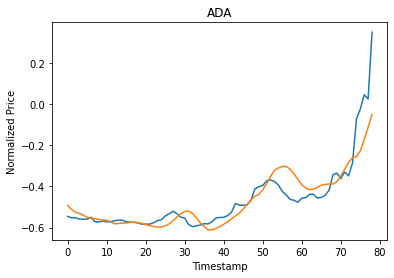

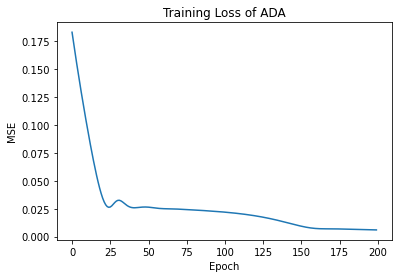

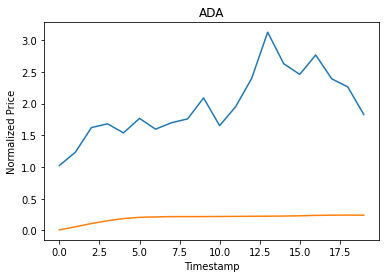

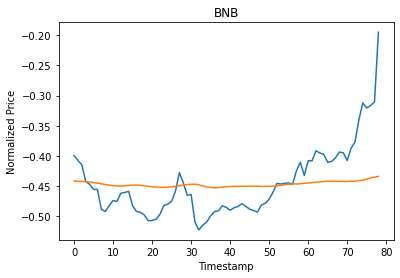

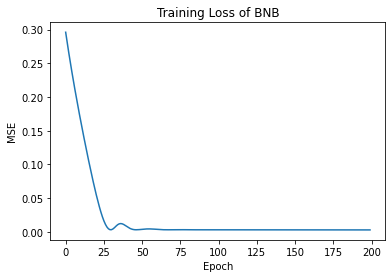

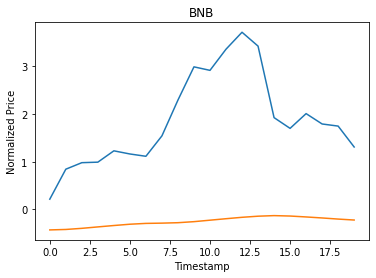

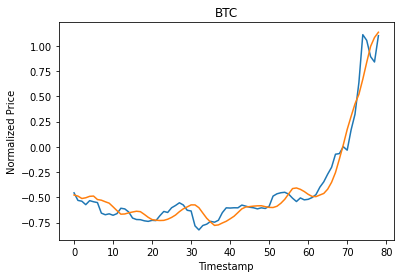

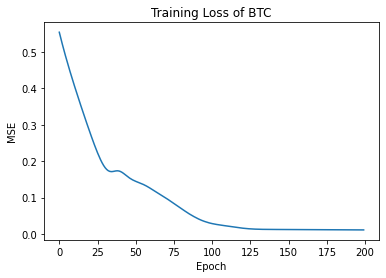

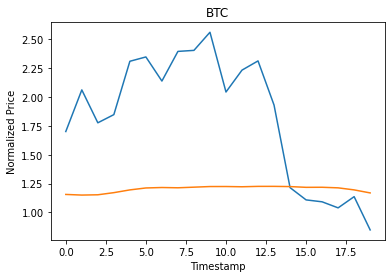

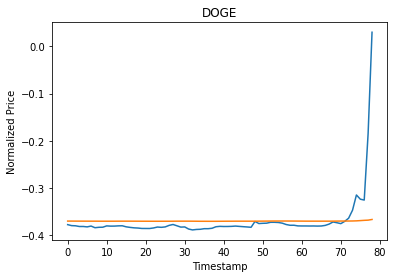

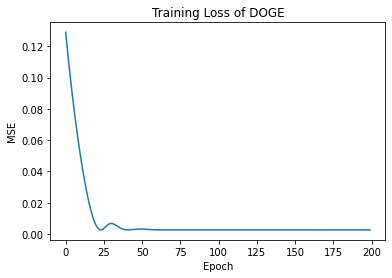

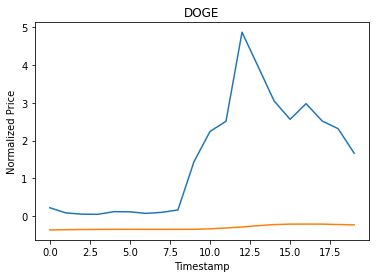

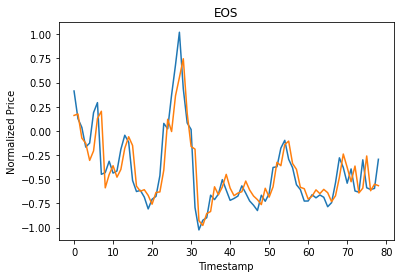

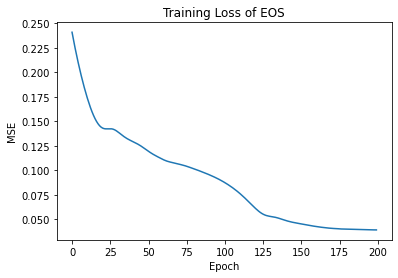

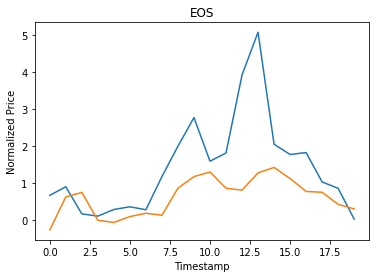

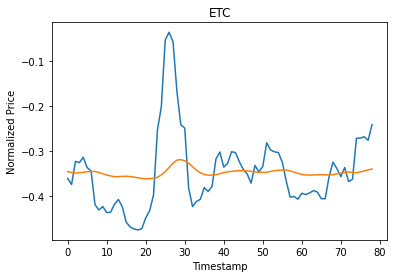

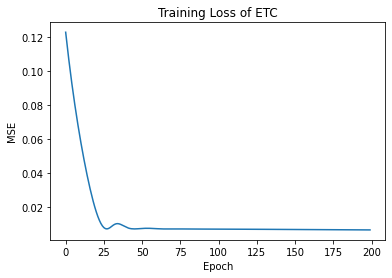

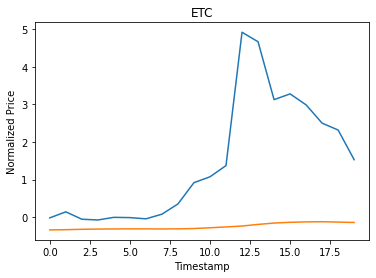

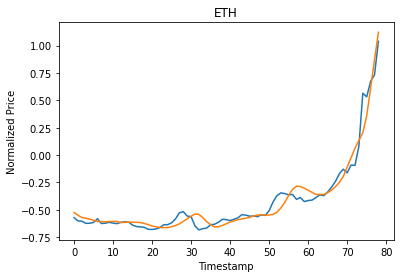

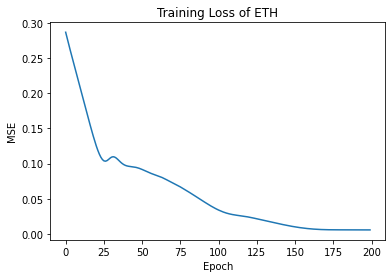

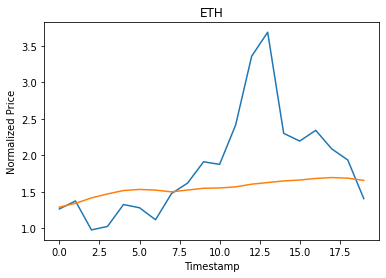

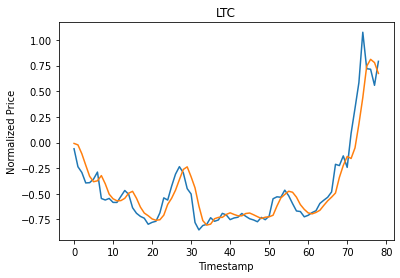

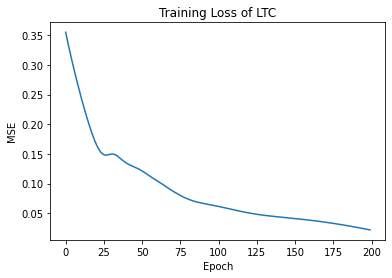

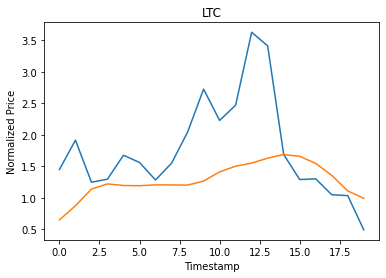

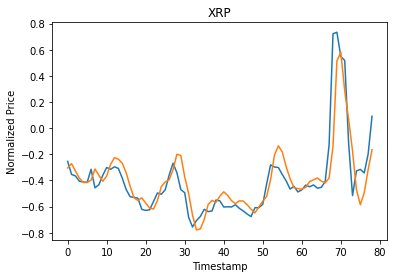

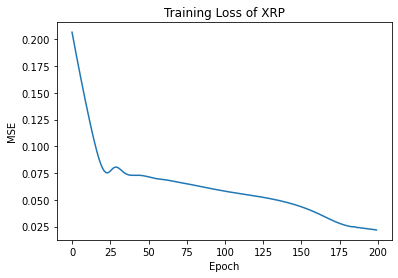

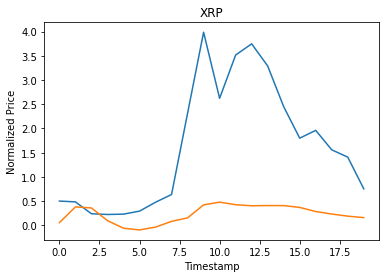

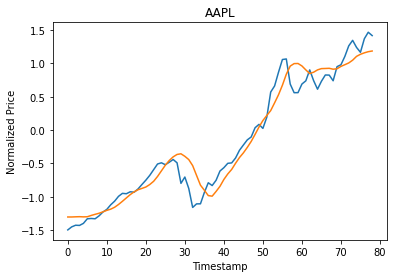

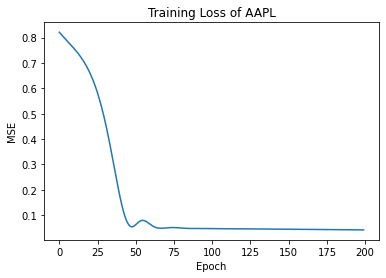

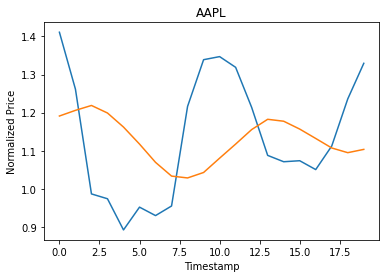

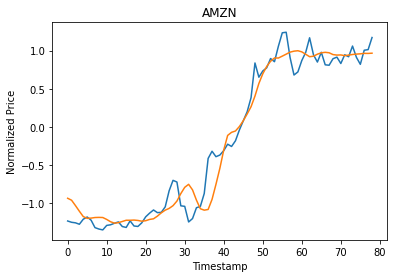

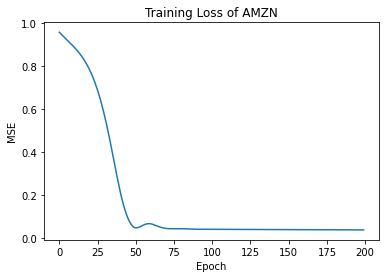

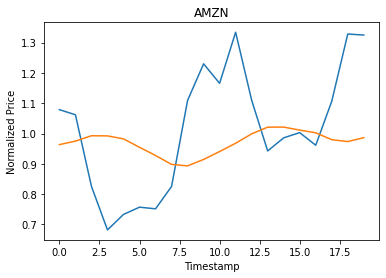

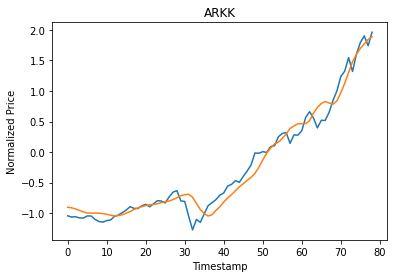

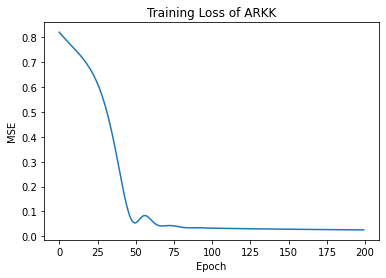

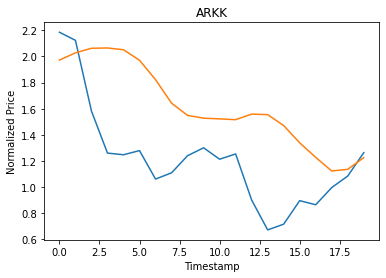

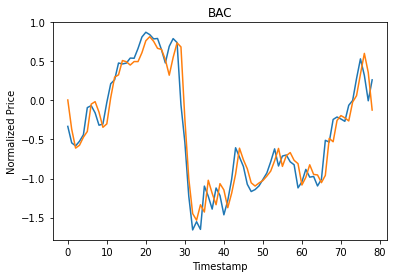

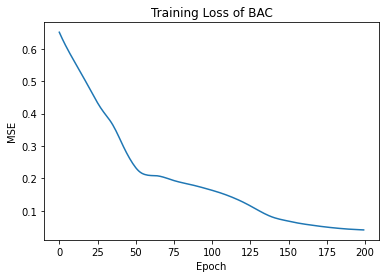

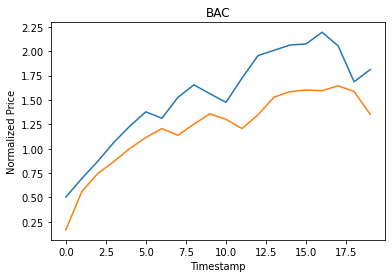

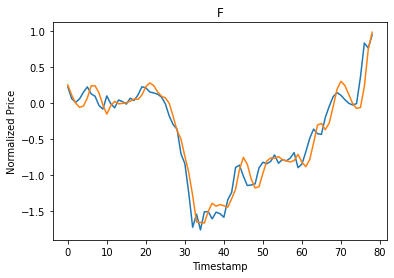

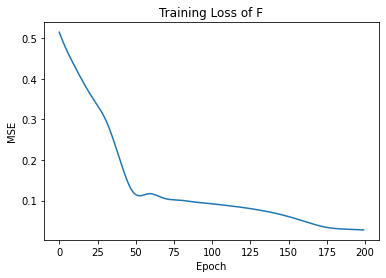

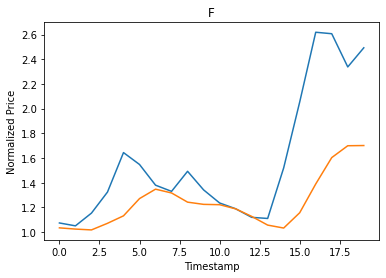

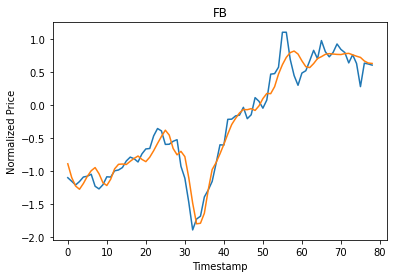

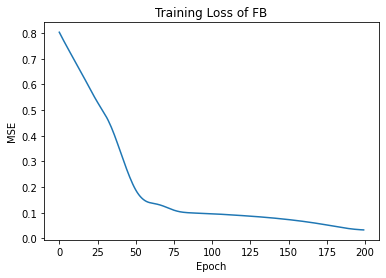

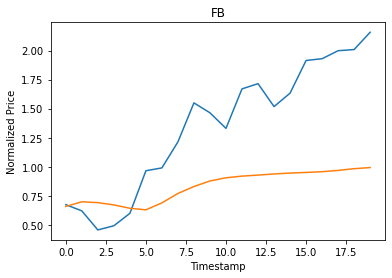

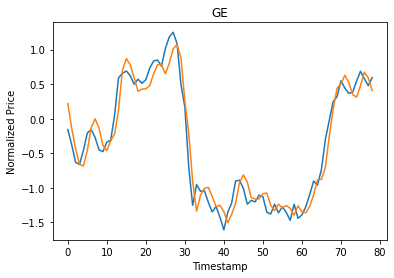

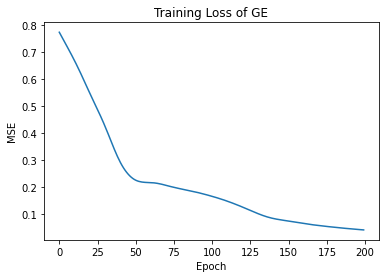

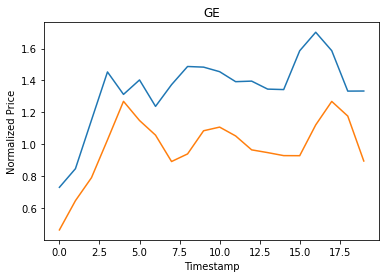

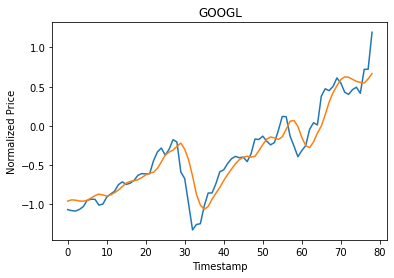

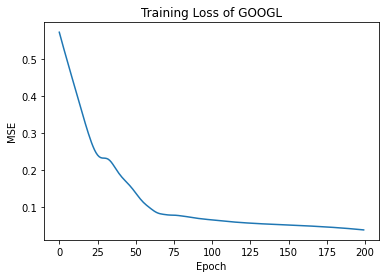

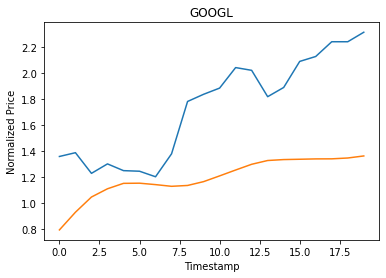

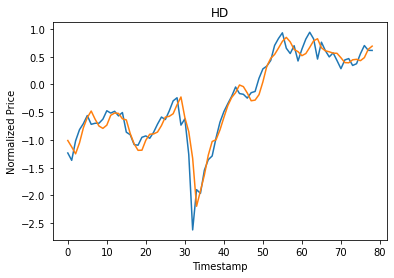

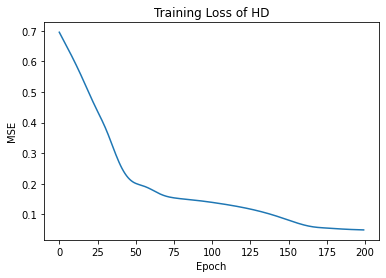

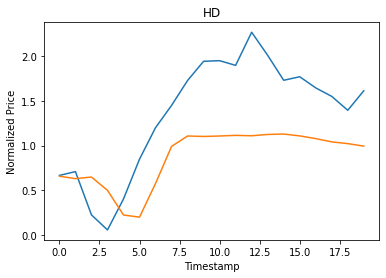

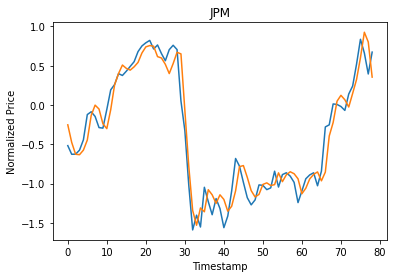

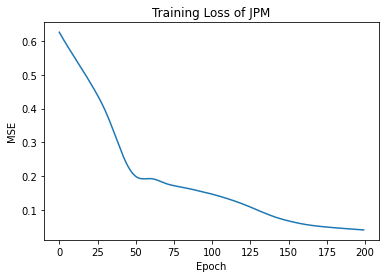

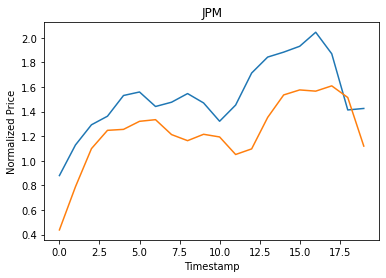

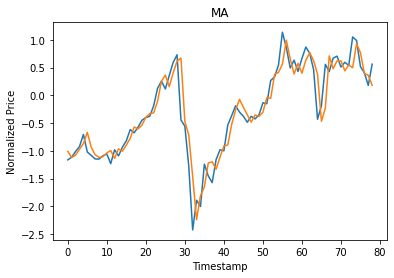

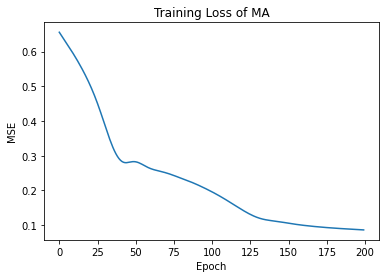

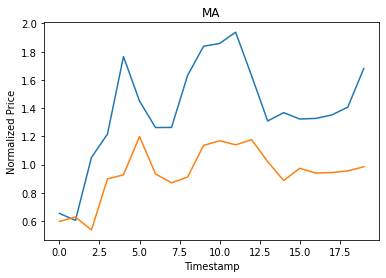

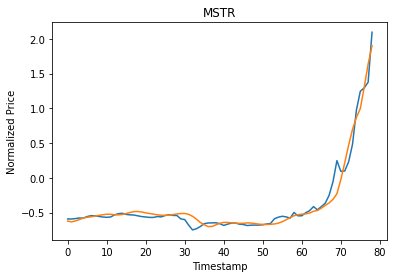

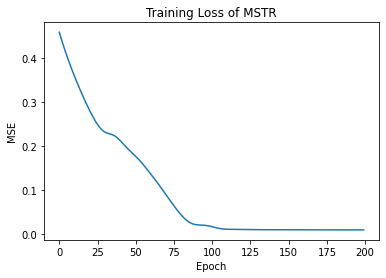

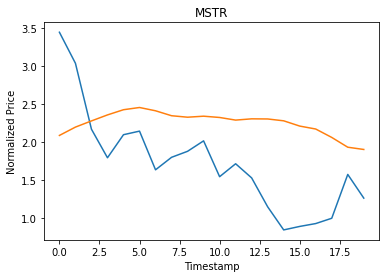

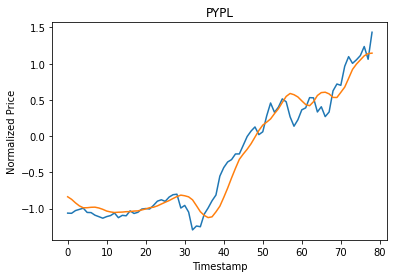

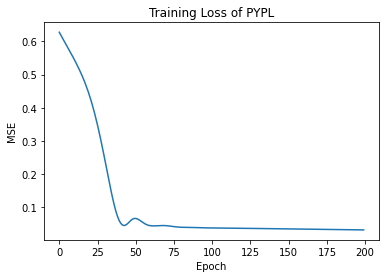

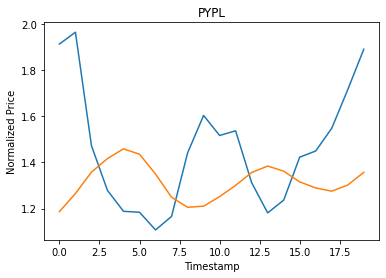

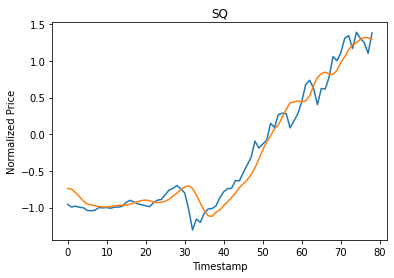

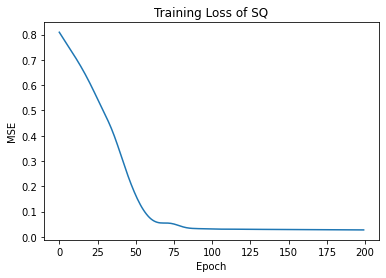

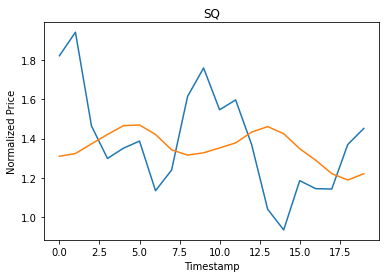

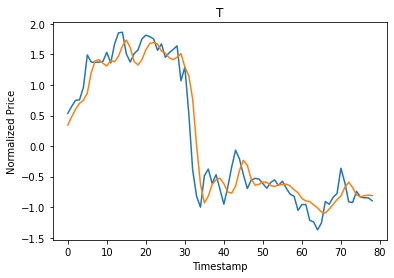

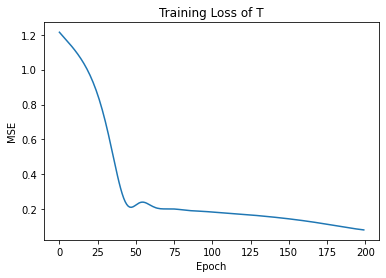

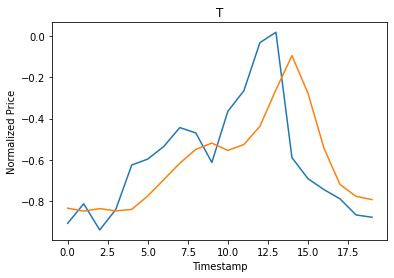

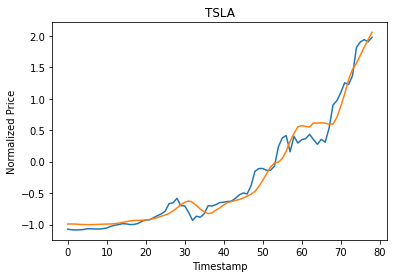

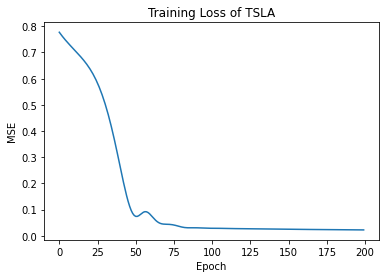

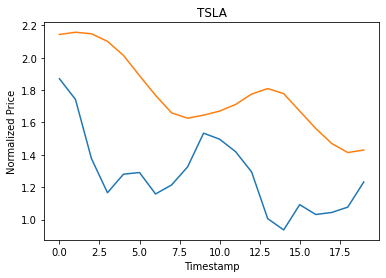

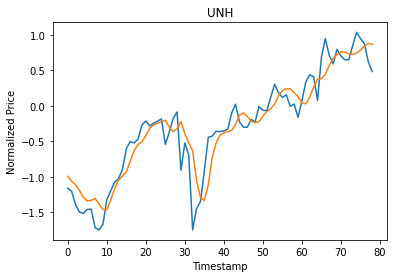

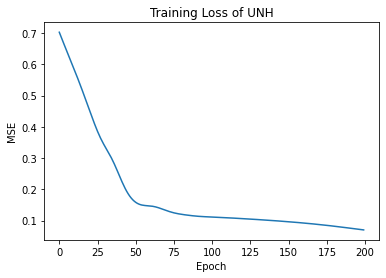

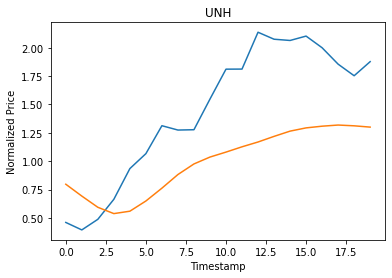

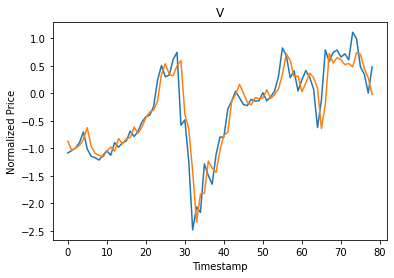

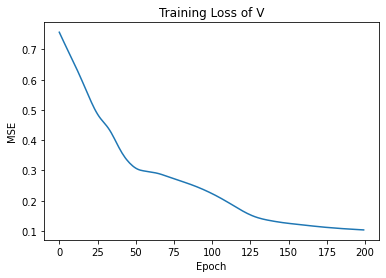

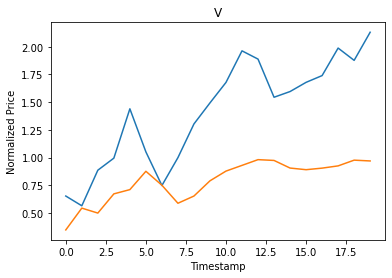

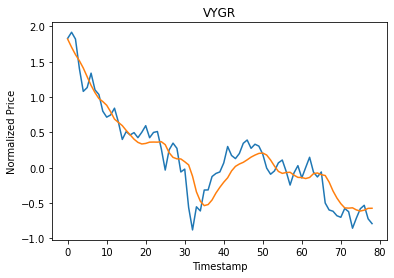

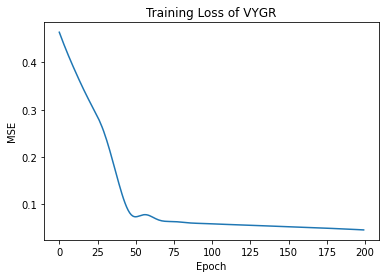

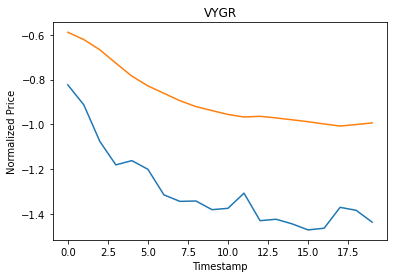

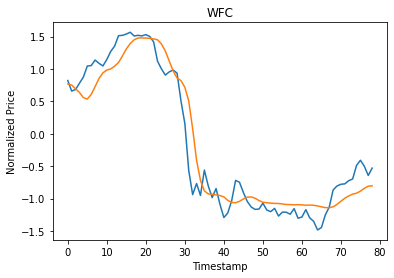

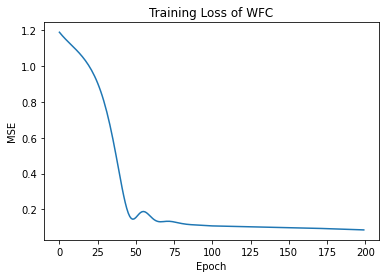

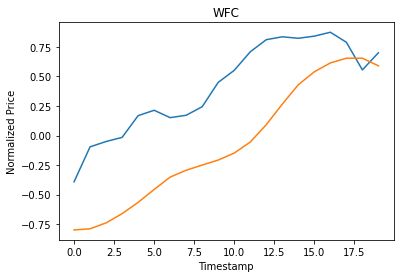

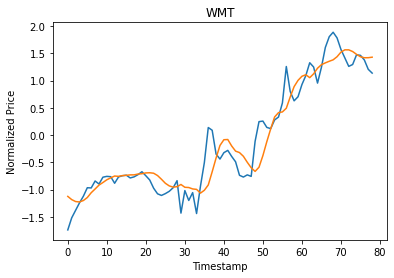

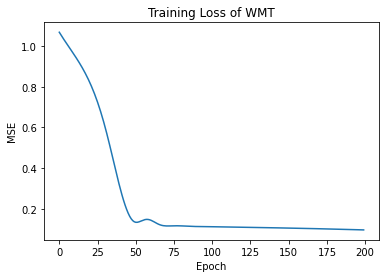

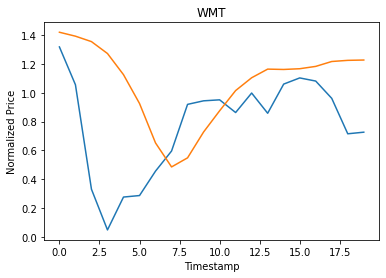

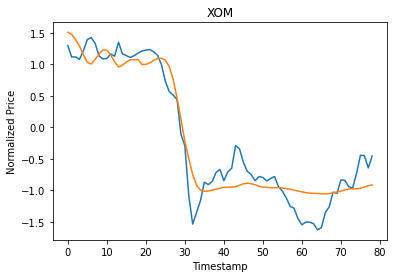

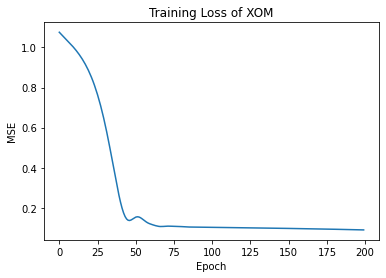

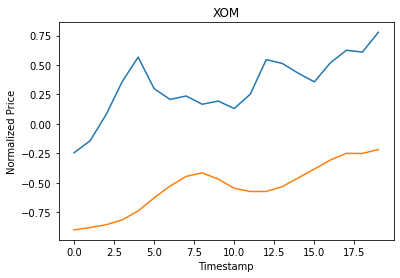

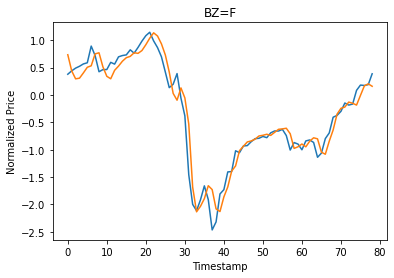

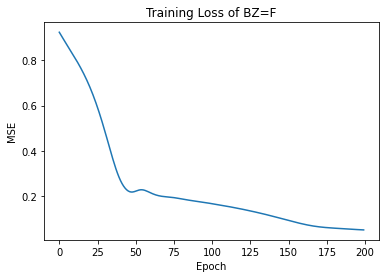

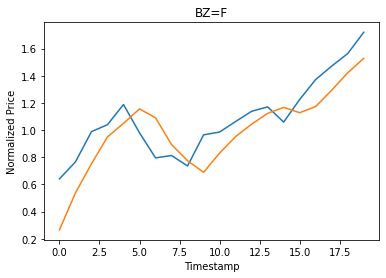

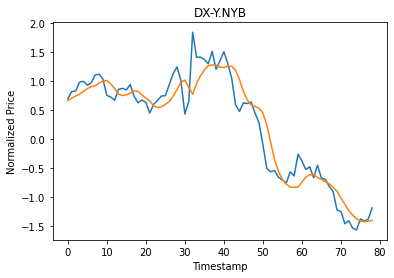

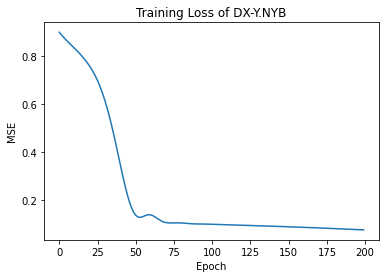

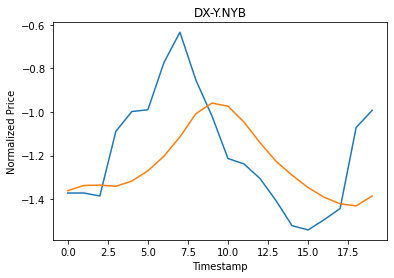

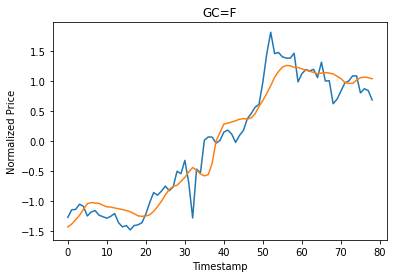

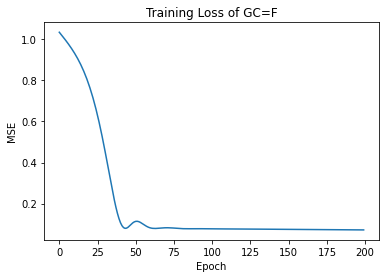

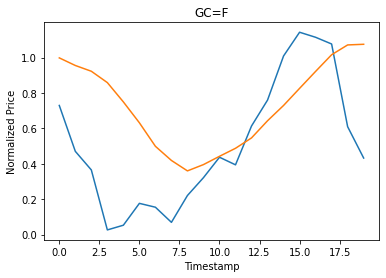

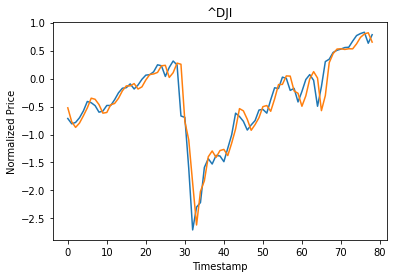

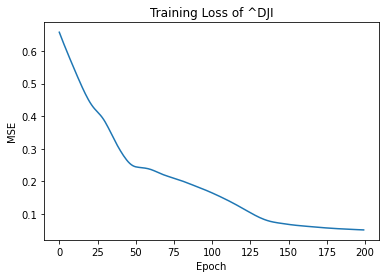

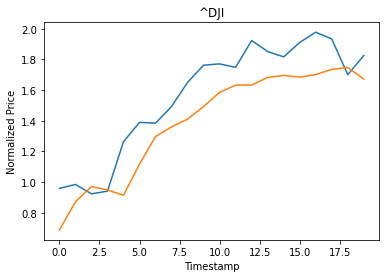

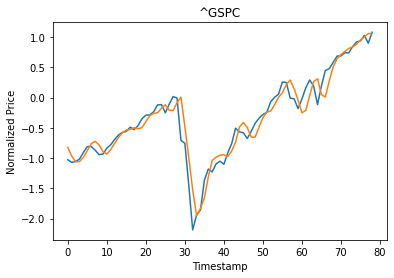

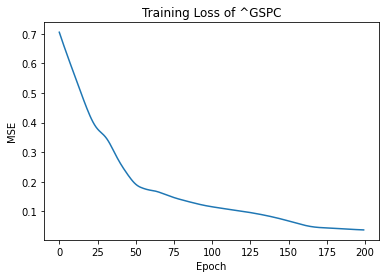

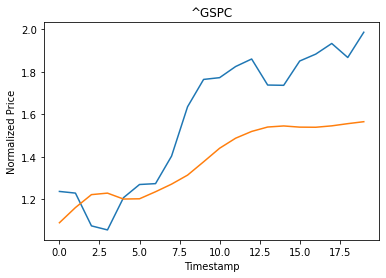

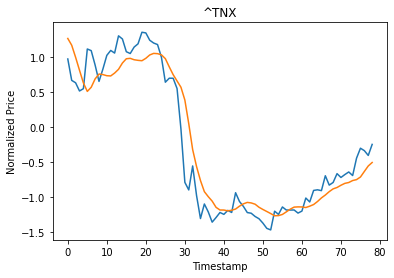

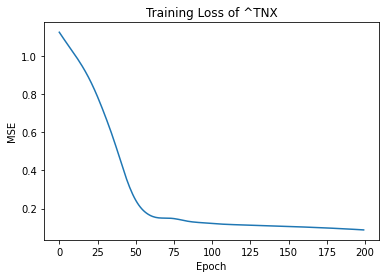

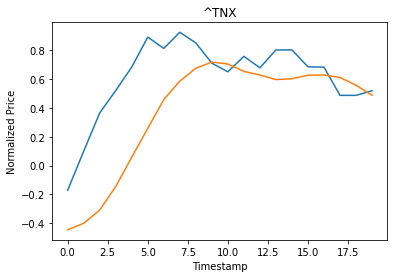

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

criteria = nn.MSELoss(reduction = "mean")

train_loss, test_loss, acc_result, c_tl, s_tl, o_tl, c_ta, s_ta, o_ta = [], [], [], [], [], [], [], [], []


for n in range(len(names)):
    all_train_y, train_y = get_all_y_and_y(train_data, names, TRAINING_LENGTH, n)
    m, loss_list = training(train_data, train_y, n, device)
    train_seq = split_input(train_data, n)
    pred_train = m(train_seq)
    plot_prediction_against_truth(pred_train, train_y, n) 
    # plot the pred_vs_truth for test
    plot_loss(loss_list, n)
    # plot loss
    train_loss.append(criteria(pred_train, train_y.to(device)))          
    all_test_y, test_y= get_all_y_and_y(test_data, names, TRAINING_LENGTH, n)
    test_seq = split_input(test_data, n)
    pred_train = m(train_seq)
    # m.reset_hidden_state() # uncomment this when using stateless LSTM 
    pred_test = m(test_seq)
    tl = criteria(pred_test, test_y.to(device)).item()
    test_loss.append(tl)
    plot_prediction_against_truth(pred_test, test_y, n) 
    # plot the pred_vs_truth for train
    
    validation_actual = np.sign(test_data.iloc[TRAINING_LENGTH-1:-1, n+1:n+2].copy().to_numpy() - test_y.detach().to('cpu').numpy())
    #validation_pred = np.sign(np.concatenate((test_data.iloc[TRAINING_LENGTH-1:TRAINING_LENGTH, 36+1:36+2].copy().to_numpy(), pred_test.detach().to('cpu').numpy()[:-1]), axis=0) - pred_test.detach().to('cpu').numpy())
    validation_pred = np.sign(test_data.iloc[TRAINING_LENGTH-1:-1, n+1:n+2].copy().to_numpy() - pred_test.detach().to('cpu').numpy())
    acc = sum(validation_actual == validation_pred) / pred_test.shape[0]
    acc_result.append(acc)
    
    if names[n] in crypto:
        c_tl.append(tl)
        c_ta.append(acc)
        
    elif names[n] in stock:
        s_tl.append(tl)
        s_ta.append(acc)
        
    elif names[n] in others:
        o_tl.append(tl)
        o_ta.append(acc)
        

In [15]:
# Different LSTM for different type of data
# Transform input feature e.g. MLP
# Visualize attention weights distinguishable between two timestamp
# Baseline only LSTM

In [16]:
print("Average MSE for all assets on test data is \t \t" + str(sum(test_loss)/len(test_loss)))
print("Average MSE for crypto data only on test data is \t" + str(sum(c_tl)/len(c_tl)))
print("Average MSE for stock data only on test data is \t" + str(sum(s_tl)/len(s_tl)))
print("Average MSE for other data only on test data is \t" + str(sum(o_tl)/len(o_tl)))
print()
print("Average accuracy for all assets on test data is \t" + str(float(sum(acc_result)/len(acc_result))))
print("Average accuracy for crypto data only on test data is \t" + str(float(sum(c_ta)/len(c_ta))))
print("Average accuracy for stock data only on test data is \t" + str(float(sum(s_ta)/len(s_ta))))
print("Average accuracy for other data only on test data is \t" + str(float(sum(o_ta)/len(o_ta))))

Average MSE for all assets on test data is 	 	0.8866549931164529
Average MSE for crypto data only on test data is 	2.9209215905931263
Average MSE for stock data only on test data is 	0.2742684160951864
Average MSE for other data only on test data is 	0.08067254597942035

Average accuracy for all assets on test data is 	0.4432432432432432
Average accuracy for crypto data only on test data is 	0.47777777777777786
Average accuracy for stock data only on test data is 	0.43636363636363645
Average accuracy for other data only on test data is 	0.4166666666666667
